### Preliminary
* get model (trained) and test it
* graph the result

In [26]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
import subprocess
import seaborn as sns

#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [27]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

84
(172, 5)
(172, 5)
(172, 74)


In [28]:
t_days = 40
pred_days = test_d
total_days = case_train.shape[1]

country_train_X = []
country_train_Y = []

country_valid_X = []
country_valid_Y = []

country_test_X = []
country_test_Y = []


for i in range(len(countries)):
    # split dataset
    cur_c = [] # current country 
    out = []
    
    cur_v = [] # current country 
    out_v = []
    
    cur_t = [] # current country 
    out_t = []
    
    for j in range(total_days-pred_days-t_days): 
        
        #print(j)
        #print(case_train[i,j:j+t_days].shape)
        #print(len(case_train[i,j+t_days]))
        cur_c.append(case_train[i,j:j+t_days])
        #print(str(j))
        out.append(case_train[i,j+t_days:j+t_days+pred_days])
        #print(len(cur_c))
    
    country_train_X.append(cur_c)
    country_train_Y.append(out)
    
    country_valid_X.append(case_train[i,-t_days:])
    country_valid_Y.append(case_validation[i])
    
    country_test_X.append(casesA[i,days-test_d-t_days:days-test_d])
    country_test_Y.append(case_test[i])



In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        return y_pred.view(-1)

    


In [30]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred, y)
            test_loss += loss.item() 
            
    return pred,test_loss




In [31]:
model_name = countries[0]
output_file_path = "./outputs/" + model_name + "/training/"

In [32]:
country_test_Y[0]
#model.load_state_dict(torch.load(output_file_path+countries[0]+".th"))
md = torch.load(output_file_path+countries[0]+".th")
#md.eval()

In [33]:
def find_min_file(path):
    with open(path,'r') as f1:
        doc = f1.readlines()
        minimum_err = 1e20
        for line in doc:
            line = line.replace('\n','')
            wdr = line.split(',')
            err = float(wdr[1])
            if err < minimum_err:
                minimum_err = err
    return(minimum_err)

In [34]:
def find_min_val(country):
    
    lr_list = [0.1,0.01,0.001,0.005,1e-4,5e-4,1e-5,1e-6]
    hidden_lst = [1,2,3,4,5]
    hState_lst = [30,50,100,200,300]
    
    model_name = country
    output_file_path = "./offline/" + model_name + "/training/"
    directory = os.path.dirname(output_file_path)
    best_param = [0,0,0]
    best_verror = 1e20
    
    for j in range(len(lr_list)):
        for k in range(len(hidden_lst)): # hidden layer
            for m in range(len(hState_lst)): # hidden state
                
                learning_rate = lr_list[j]
                hidden_dim = hState_lst[m]
                num_layers = hidden_lst[k]
    
                #train_error = open(output_directory + "training_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "a")
                fname = output_file_path + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt"
                #lastline = subprocess.check_output(['tail', '-1', fname]).decode("utf-8")  #(output_directory + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "r")
                
                err = find_min_file(fname)
                
                if err < best_verror:
                    best_verror = err
                    best_param = [learning_rate,hidden_dim,num_layers]
    
    print(best_verror)
    return(best_param)

In [35]:
print(countries[0])
find_min_val(countries[0])

Burundi
0.03181177005171776


[0.005, 50, 5]

In [36]:
#casesA[0,:].tolist()
a = [1,1,2]#.append([3,4])
print(a)
countries[0]

[1, 1, 2]


'Burundi'

In [37]:
a.extend([3,4])
a
np.linspace(1, len(casesA[0,:].tolist()), len(casesA[0,:].tolist()))

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82., 83., 84.])

In [38]:
import matplotlib.pyplot as plt

def graph_country(index,prediction,outdir):
    
    # produce projection closeup & general graph
    # with label & title
    #print(prediction)
    newpred = prediction#.tolist()
    
    # general trend
    x = np.linspace(1, len(casesA[index,:].tolist()), len(casesA[index,:].tolist()))
    y_real = casesA[index,:]
    y_pred = casesA[index,:days-test_d].tolist()
    #print(len(y_pred))
    y_pred.extend(newpred)
    #print(len(y_pred))
    #print(len(y_real))
    y_pred = np.array(y_pred)
    plt.figure(index)
    plt.plot(x, y_real, label = "real")
    plt.plot(x, y_pred, label = "prediction")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" trend")
    plt.savefig(outdir+countries[i]+"_general")
    plt.show()
    # specific plot
    x = np.linspace(1, len(casesA[index,days-test_d:].tolist()), len(casesA[index,days-test_d:].tolist()))
    y_real = casesA[index,days-test_d:]
    y_pred = newpred
    plt.figure(index*2)
    plt.plot(x, y_real, label = "real")
    plt.plot(x, y_pred, label = "prediction")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" 5 days prediction")
    plt.savefig(outdir+countries[i]+"_specific")    
    plt.show()

In [39]:
def brute_structure():
    
    for i in range(len(countries)):
    

        lr_list = [0.1,0.01,0.001,0.005,1e-4,5e-4,1e-5,1e-6]
        hidden_lst = [1,2,3,4,5]
        hState_lst = [30,50,100,200,300]

        model_name = countries[i]
        output_file_path = "./offline/" + model_name + "/training/"
        directory = os.path.dirname(output_file_path)
        best_param = [0.1,1,30]
        best_verror = 1e20

        for j in range(len(lr_list)):
            for k in range(len(hidden_lst)): # hidden layer
                for m in range(len(hState_lst)): # hidden state
                    
                    learning_rate = lr_list[j]
                    hidden_dim = hState_lst[m]
                    num_layers = hidden_lst[k]

                    net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
                    #print(net)
                    model = net.to(device)
                    try:
                        model.load_state_dict(torch.load_encoder(output_file_path+countries[i]+".th"))
                        print(countries[i],": ",best_param)
                    except:
                        continue


In [40]:
# 
#brute_structure()
lstm_input_size = t_days
batch_size = 1
output_dim = pred_days
net =  LSTM(40, 30, batch_size=1, output_dim=5, num_layers=5)
print(net)
model = net.to(device)

model.load_state_dict(torch.load(output_file_path+countries[0]+".th"))
# hidden state = 30, 

LSTM(
  (lstm): LSTM(40, 30, num_layers=5)
  (linear): Linear(in_features=30, out_features=5, bias=True)
)


<All keys matched successfully>

In [41]:
torch.load(output_file_path+countries[0]+".th")['lstm.weight_ih_l0'].shape[0]

120

In [42]:
max([1,1,3])
max(country_test_Y[0])

0.4204938616306079

Directory ./graph/ exists
tensor([[0.2523, 0.4205, 0.4205, 0.4205, 0.4205]], device='cuda:0')
tensor([-7.5973e-07,  5.4855e-07, -6.6645e-06,  6.8918e-08, -4.5388e-06],
       device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


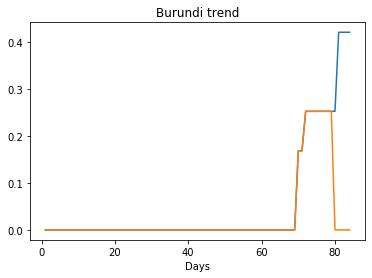

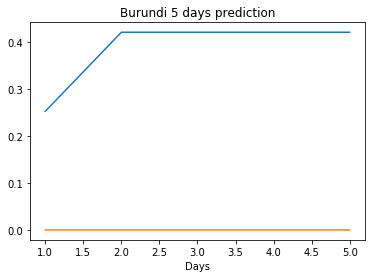

tensor([[151.8219, 189.2713, 216.5992, 301.6194, 367.4089]], device='cuda:0')
tensor([25.0494, 26.5881, 24.1320, 25.9953, 33.4208], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


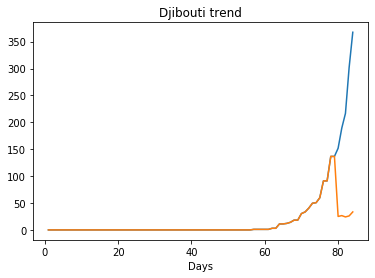

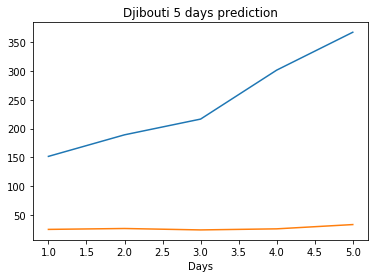

tensor([[9.5871, 9.5871, 9.5871, 9.5871, 9.5871]], device='cuda:0')
tensor([ 3.8791,  6.4656,  8.6163,  9.5894, 13.9990], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


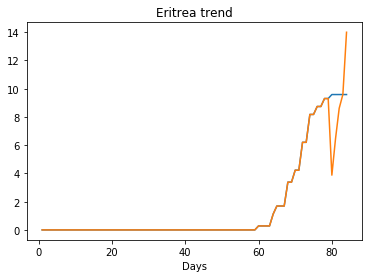

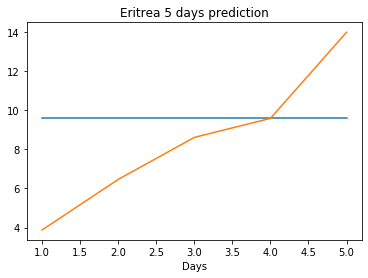

tensor([[0.5654, 0.6002, 0.6176, 0.6437, 0.7133]], device='cuda:0')
tensor([0.0271, 0.0359, 0.0481, 0.0571, 0.0629], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


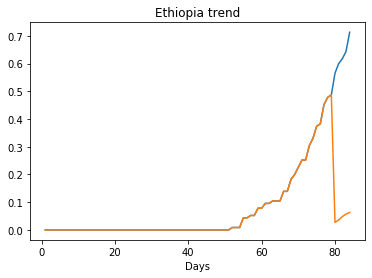

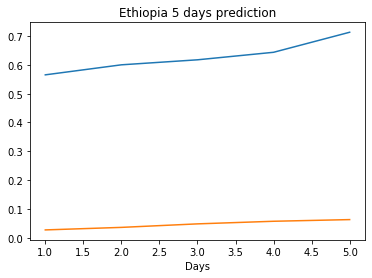

tensor([[3.5149, 3.5521, 3.6637, 3.8682, 4.0170]], device='cuda:0')
tensor([2.9333, 3.5096, 3.7705, 4.4244, 4.8437], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


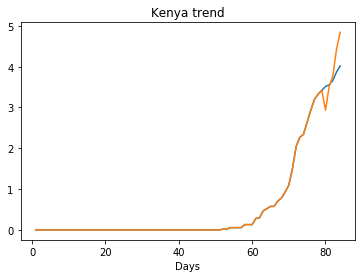

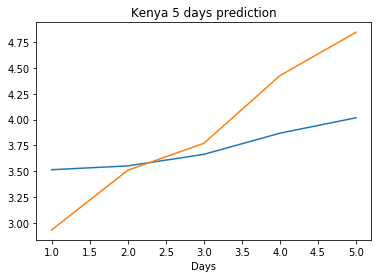

tensor([[3.3585, 3.6835, 3.8280, 3.8280, 3.9002]], device='cuda:0')
tensor([2.2952, 2.6912, 3.2426, 3.3870, 4.3529], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


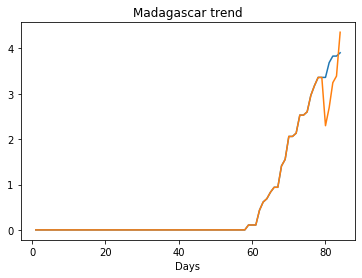

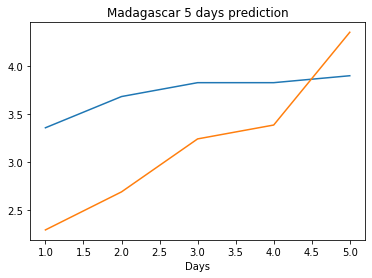

tensor([[0.4705, 0.6273, 0.6796, 0.8364, 0.8364]], device='cuda:0')
tensor([-0.0402, -0.0100,  0.0160, -0.0204,  0.0088], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


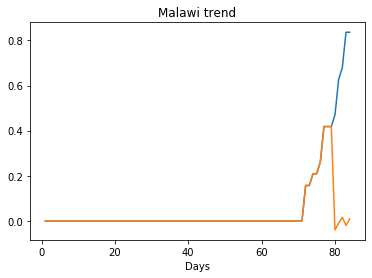

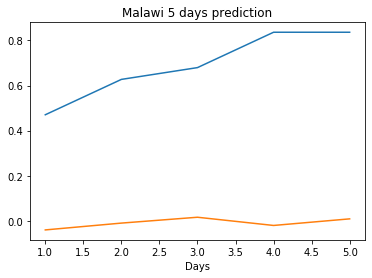

tensor([[250.0452, 250.8315, 254.7630, 254.7630, 254.7630]], device='cuda:0')
tensor([ 60.1680,  67.0358,  95.7226, 101.4282, 141.0803], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


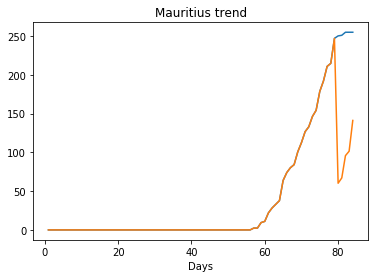

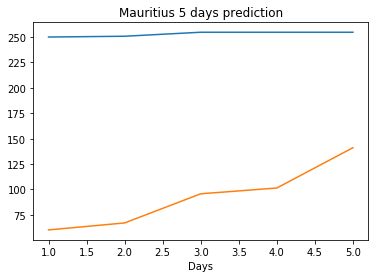

tensor([[0.6399, 0.6399, 0.6719, 0.6719, 0.8958]], device='cuda:0')
tensor([-0.0069,  0.0260,  0.0512,  0.0421,  0.0422], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


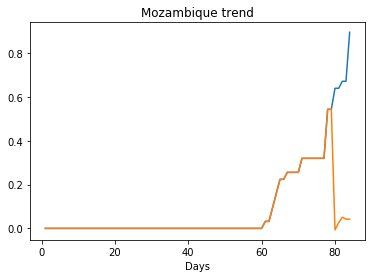

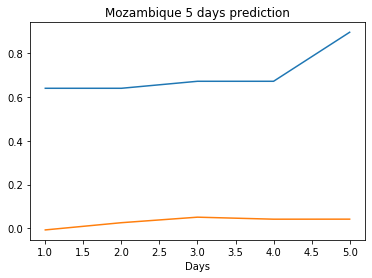

tensor([[ 9.1104,  9.2648,  9.7281,  9.8053, 10.3457]], device='cuda:0')
tensor([5.0261, 5.0062, 5.3494, 6.2534, 6.2051], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


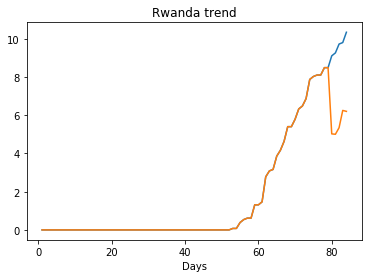

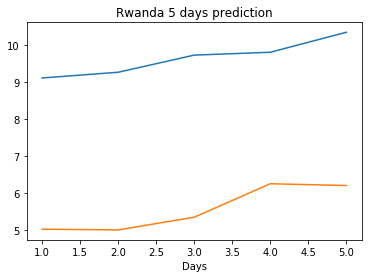

tensor([[111.8568, 111.8568, 111.8568, 111.8568, 111.8568]], device='cuda:0')
tensor([-47.8203, -41.3841, -34.7620, -35.4826, -28.7334], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


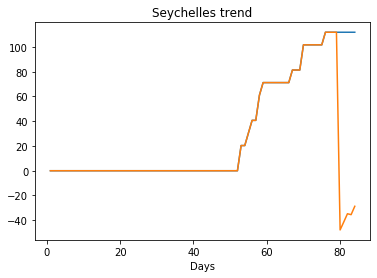

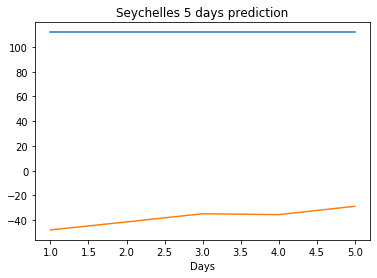

tensor([[1.3213, 1.3213, 1.5730, 3.7752, 3.7752]], device='cuda:0')
tensor([0.0410, 0.0516, 0.0774, 0.0752, 0.0809], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


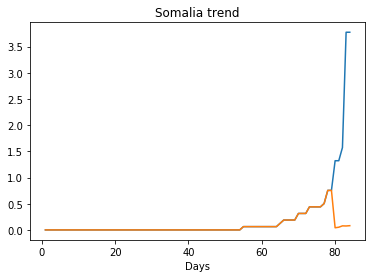

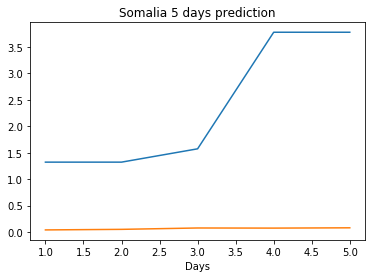

tensor([[0.3573, 0.3573, 0.3573, 0.3573, 0.3573]], device='cuda:0')
tensor([-1.2806e-08, -4.3353e-07, -3.4273e-07, -1.8161e-07,  1.3048e-06],
       device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


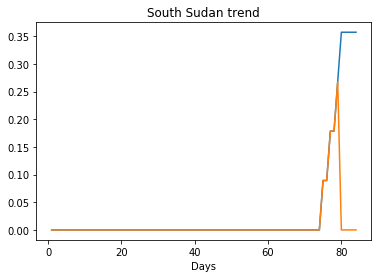

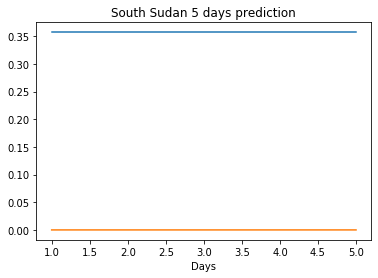

tensor([[1.1587, 1.1587, 1.1806, 1.1806, 1.2024]], device='cuda:0')
tensor([0.1878, 0.1755, 0.3073, 0.3750, 0.4611], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


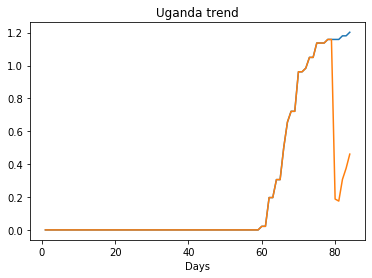

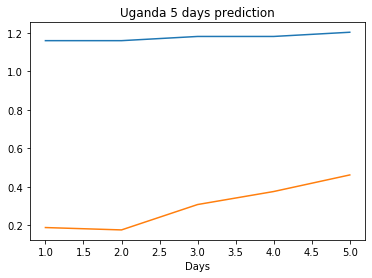

tensor([[0.5357, 0.5357, 0.5357, 0.8203, 0.8873]], device='cuda:0')
tensor([0.2637, 0.2658, 0.3095, 0.3109, 0.3136], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


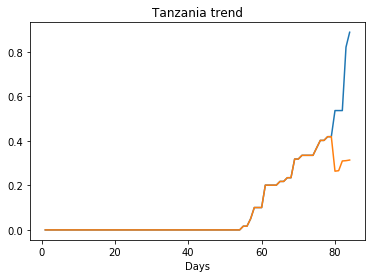

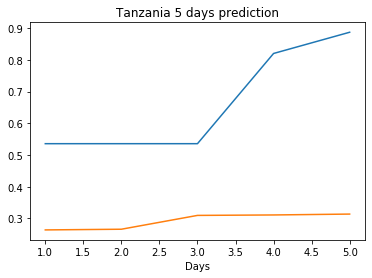

tensor([[2.1758, 2.1758, 2.3390, 2.4478, 2.4478]], device='cuda:0')
tensor([2.4604, 3.8974, 5.8224, 8.1887, 9.6532], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


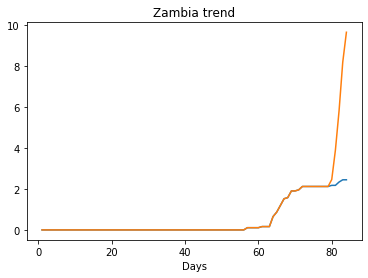

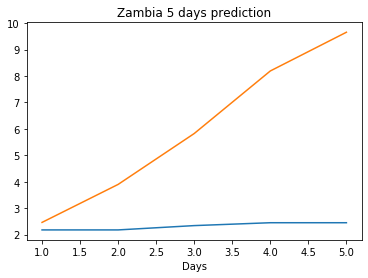

tensor([[0.8747, 0.9419, 0.9419, 1.1438, 1.1438]], device='cuda:0')
tensor([0.4071, 0.4151, 0.4310, 0.6253, 0.7647], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


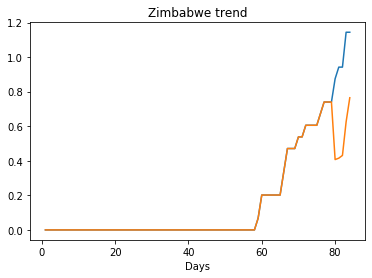

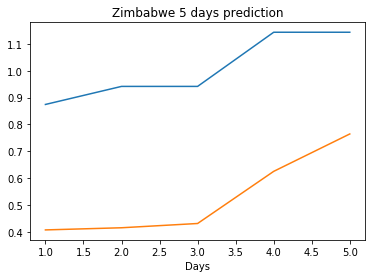

tensor([[0.5781, 0.5781, 0.5781, 0.5781, 0.5781]], device='cuda:0')
tensor([0.0622, 0.0490, 0.0364, 0.0429, 0.0728], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


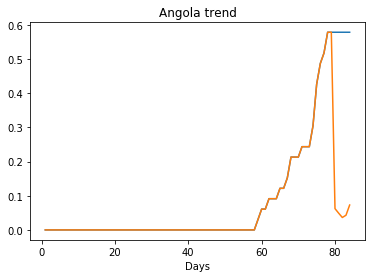

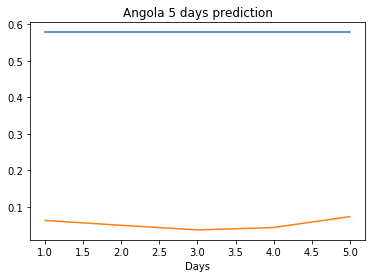

tensor([[30.8899, 30.8899, 30.8899, 30.8899, 31.9447]], device='cuda:0')
tensor([2.9634, 2.1623, 2.4652, 2.4935, 4.8210], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


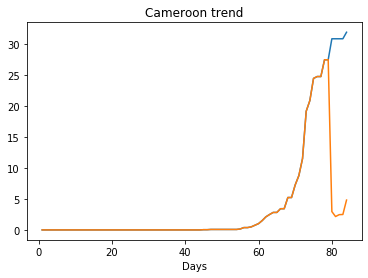

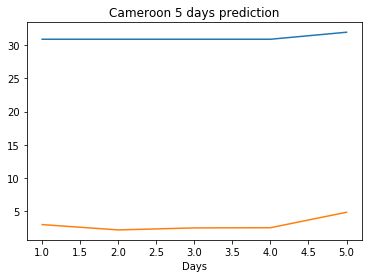

tensor([[1.6564, 1.6564, 1.6564, 2.2775, 2.2775]], device='cuda:0')
tensor([0.6850, 0.7548, 0.7989, 0.8407, 0.9357], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


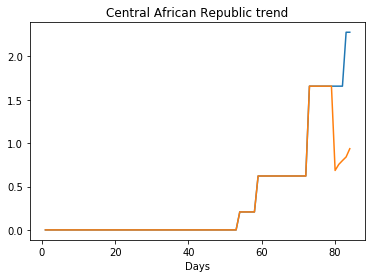

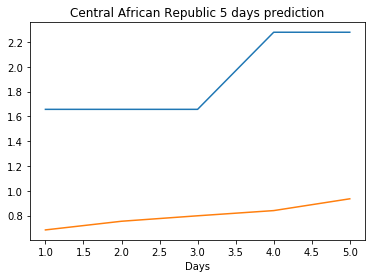

tensor([[0.6697, 0.6697, 1.0958, 1.4002, 1.4002]], device='cuda:0')
tensor([0.0595, 0.0650, 0.0793, 0.0837, 0.1031], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


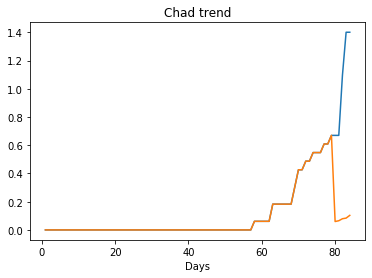

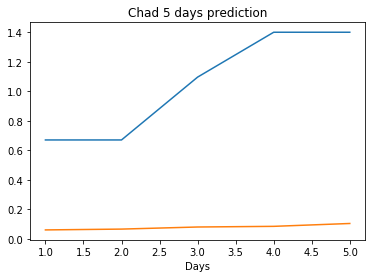

tensor([[12.8297, 12.8297, 14.9680, 14.9680, 29.2233]], device='cuda:0')
tensor([ 8.8217, 10.9436, 11.5535, 12.1564, 11.5581], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


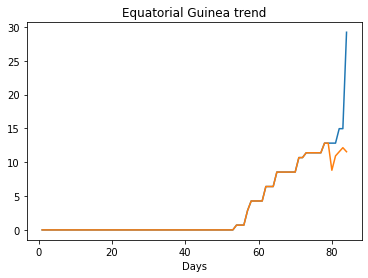

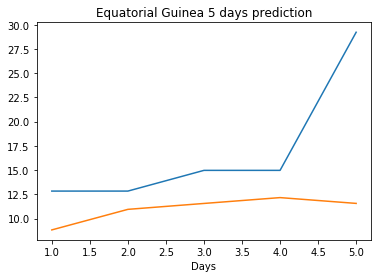

tensor([[19.7688, 20.6674, 22.0152, 25.6096, 25.6096]], device='cuda:0')
tensor([3.3535, 2.9784, 1.9101, 1.6127, 1.6002], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


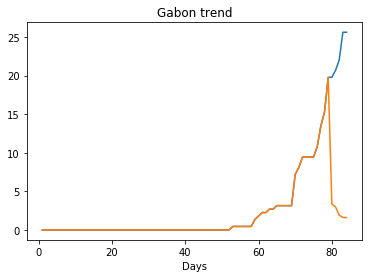

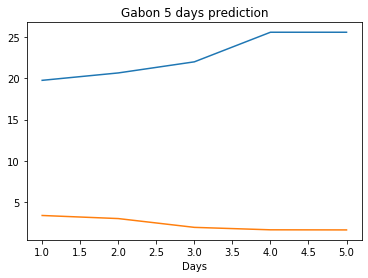

tensor([[18.2515, 18.2515, 18.2515, 18.2515, 18.2515]], device='cuda:0')
tensor([-2.7604e-05,  8.5052e-05, -4.3288e-06, -4.0727e-05,  2.3772e-05],
       device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


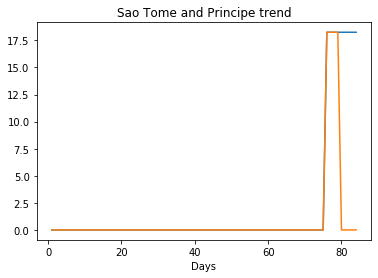

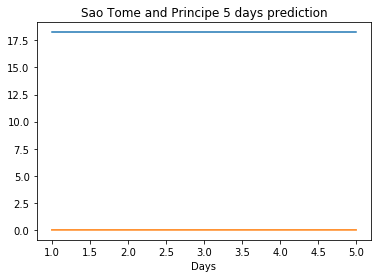

tensor([[5.5281, 5.5281, 5.5281, 5.5281, 5.5281]], device='cuda:0')
tensor([0.2200, 0.0144, 0.1078, 0.1560, 0.1427], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


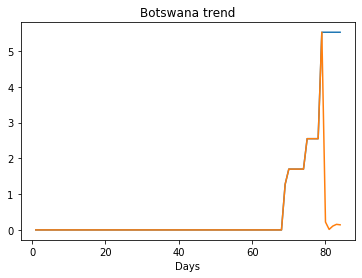

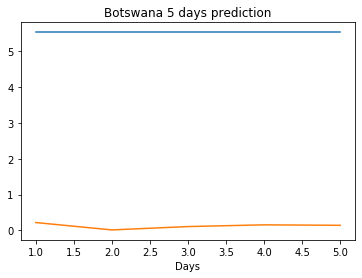

tensor([[10.3434, 10.3434, 12.0673, 12.9293, 12.9293]], device='cuda:0')
tensor([4.8064, 5.4344, 6.2998, 7.5602, 7.6006], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


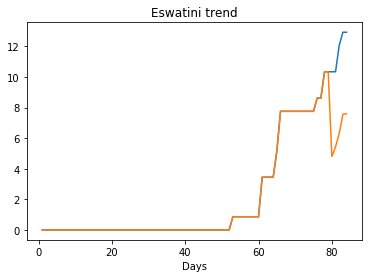

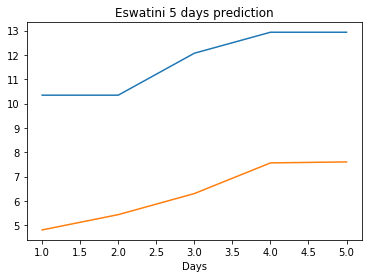

tensor([[6.2969, 6.2969, 6.2969, 6.2969, 6.2969]], device='cuda:0')
tensor([5.0427, 5.5706, 5.3454, 4.8775, 5.5353], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


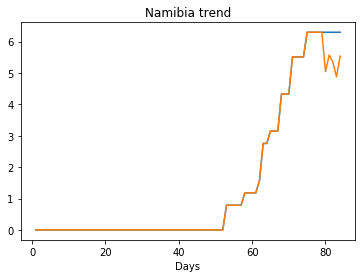

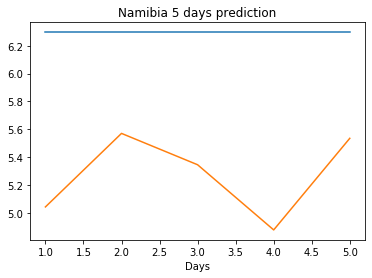

tensor([[33.7725, 34.1940, 36.6388, 38.3080, 40.7192]], device='cuda:0')
tensor([12.6132, 17.1361, 21.2689, 22.4442, 25.3535], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


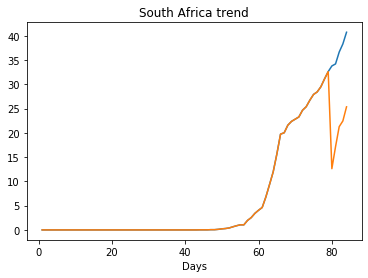

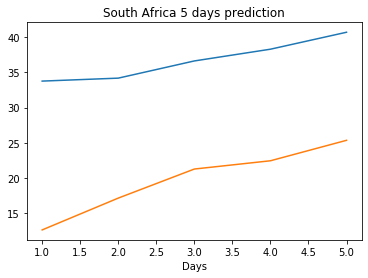

tensor([[2.8870, 2.8870, 2.8870, 2.8870, 2.8870]], device='cuda:0')
tensor([2.0900, 2.3301, 2.4460, 2.4538, 2.5007], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


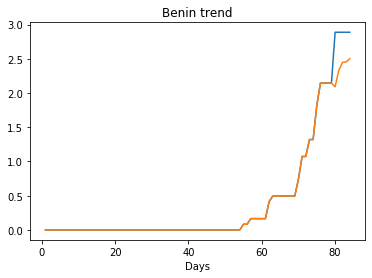

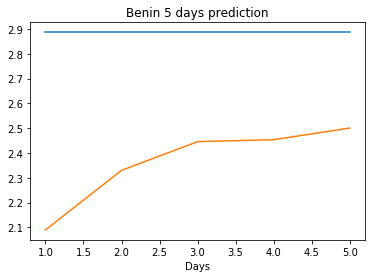

tensor([[21.1928, 23.1543, 23.7762, 23.7762, 25.2592]], device='cuda:0')
tensor([13.0992, 13.3480, 14.4014, 16.3717, 17.1390], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


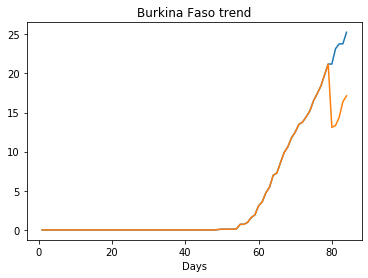

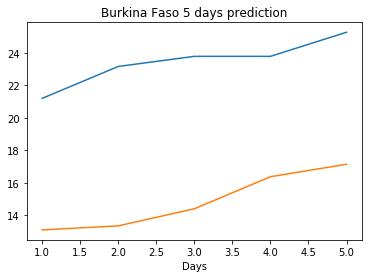

tensor([[12.5902, 14.3887, 14.3887, 17.9859, 19.7845]], device='cuda:0')
tensor([ 6.5355,  7.4802,  8.9756,  9.1263, 10.6513], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


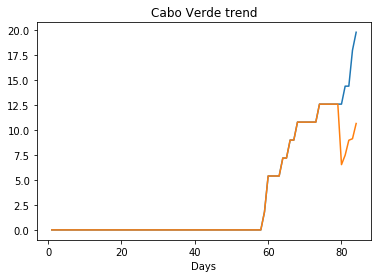

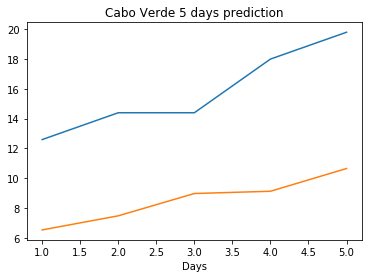

tensor([[1.6552, 3.7241, 3.7241, 3.7241, 3.7241]], device='cuda:0')
tensor([1.7866, 1.7302, 1.7833, 1.8888, 2.0912], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


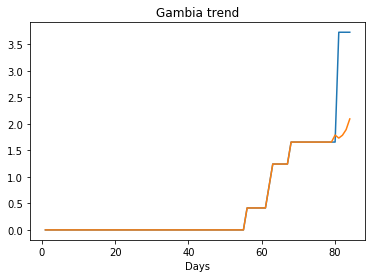

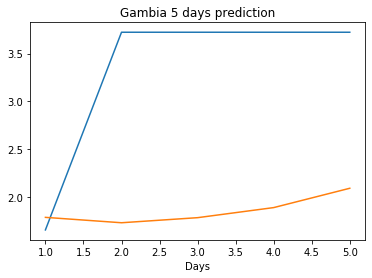

tensor([[12.1649, 13.1304, 18.2152, 18.2152, 20.4680]], device='cuda:0')
tensor([10.4557, 14.2483, 10.3241,  6.0546,  2.9512], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


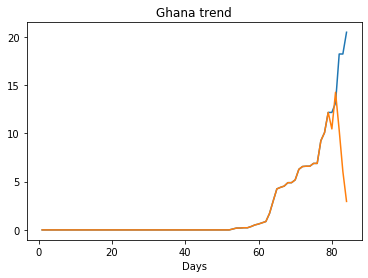

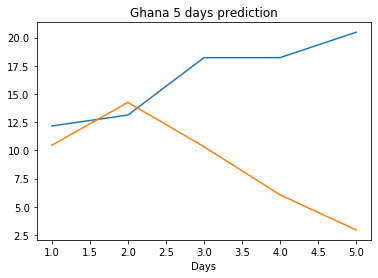

tensor([[16.1428, 19.0363, 19.0363, 24.2903, 27.6407]], device='cuda:0')
tensor([2.9211, 3.0372, 4.2207, 5.1293, 7.6353], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


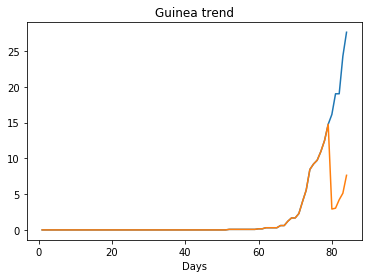

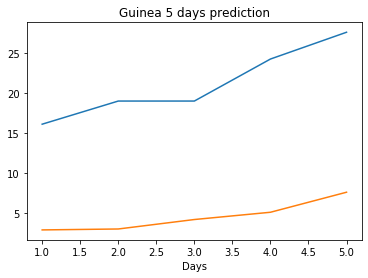

tensor([[18.2927, 19.3089, 19.3089, 19.3089, 19.3089]], device='cuda:0')
tensor([0.0109, 0.0916, 0.2245, 0.3441, 0.5010], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


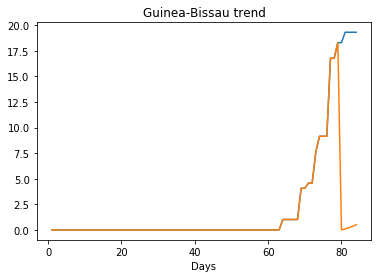

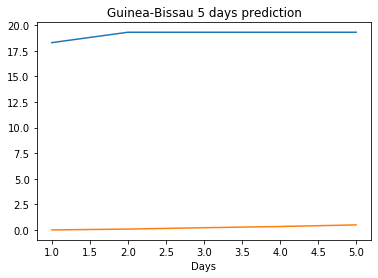

tensor([[ 7.3156,  9.4905,  9.8860, 11.6654, 11.6654]], device='cuda:0')
tensor([2.3182, 2.2599, 2.3139, 2.3480, 2.1262], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


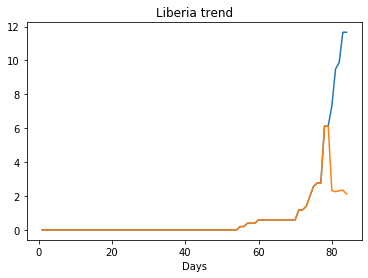

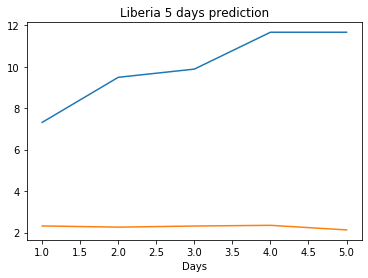

tensor([[4.2961, 4.2961, 5.1850, 6.0738, 7.1108]], device='cuda:0')
tensor([-0.0090, -0.0206, -0.0412, -0.0505,  0.0175], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


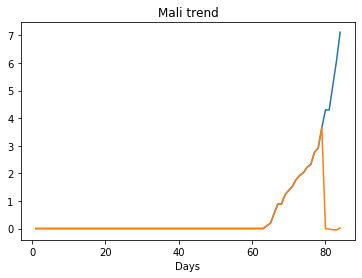

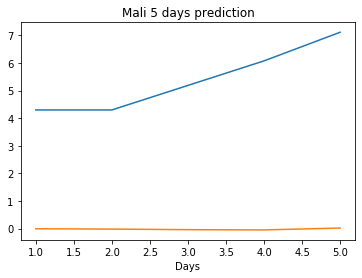

tensor([[1.5055, 1.5055, 1.5055, 1.5055, 1.5055]], device='cuda:0')
tensor([1.3170, 1.4635, 1.5253, 1.9152, 2.2714], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


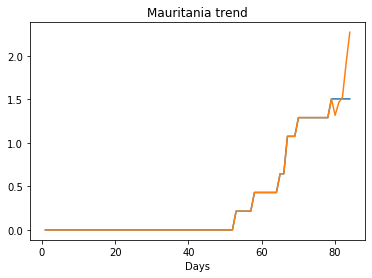

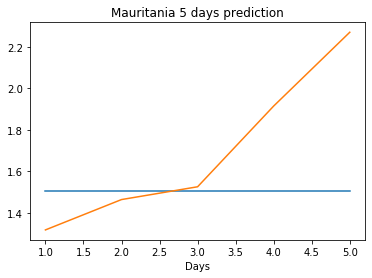

tensor([[18.0942, 20.2837, 21.8535, 21.8535, 23.5473]], device='cuda:0')
tensor([0.4839, 0.6304, 0.7318, 1.0362, 1.2933], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


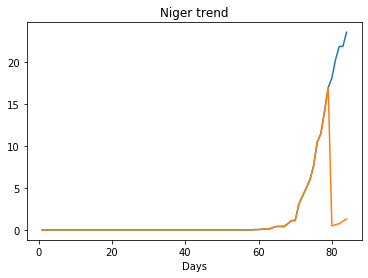

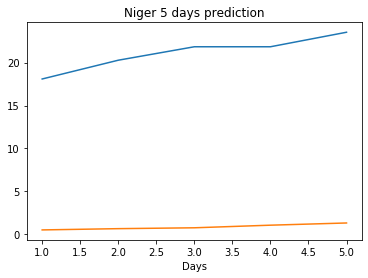

tensor([[1.4796, 1.5426, 1.5669, 1.6639, 1.8095]], device='cuda:0')
tensor([0.4053, 0.6087, 0.6877, 0.7447, 0.9103], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


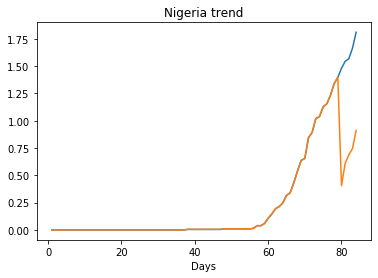

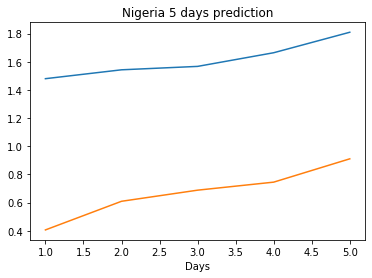

tensor([[15.8266, 16.6030, 16.7225, 17.3794, 17.8572]], device='cuda:0')
tensor([ 8.8362,  9.5076, 10.2484, 10.7650, 11.3507], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


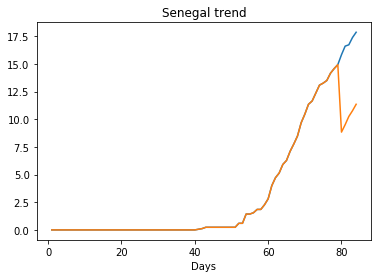

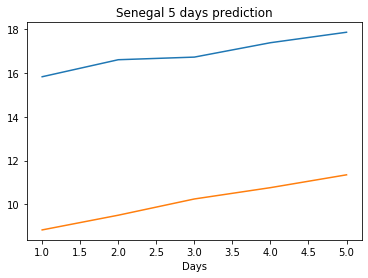

tensor([[1.0029, 1.0029, 1.2536, 1.2536, 1.3790]], device='cuda:0')
tensor([0.1542, 0.1924, 0.1217, 0.1435, 0.1605], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


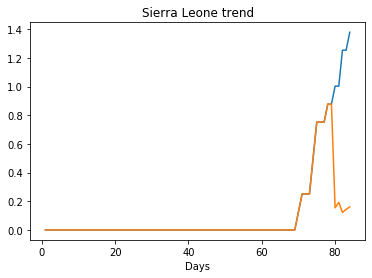

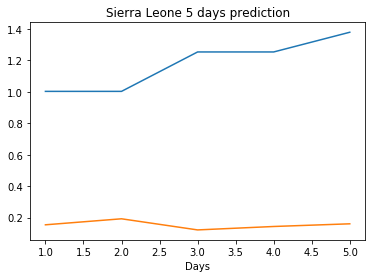

tensor([[9.1801, 9.1801, 9.1801, 9.3009, 9.3009]], device='cuda:0')
tensor([3.4319, 4.0017, 4.1646, 4.2116, 4.3730], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


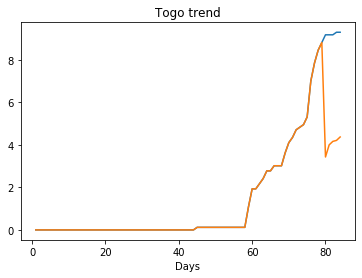

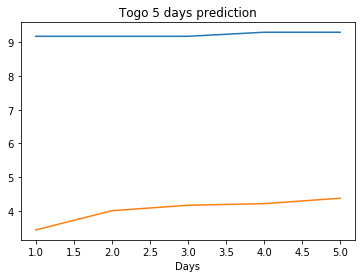

tensor([[40.1587, 41.6182, 43.6478, 45.2213, 47.2053]], device='cuda:0')
tensor([ 6.1157,  6.5332,  7.4743,  8.8205, 10.1323], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


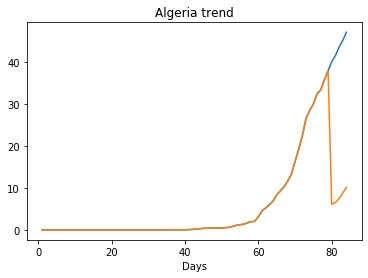

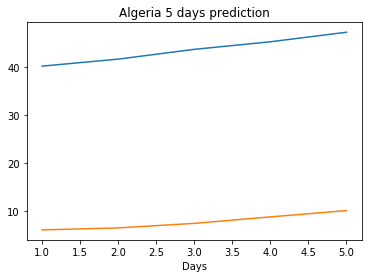

tensor([[17.5308, 18.9477, 20.1789, 21.4004, 22.9639]], device='cuda:0')
tensor([4.6636, 5.2284, 5.5336, 6.0846, 6.4805], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


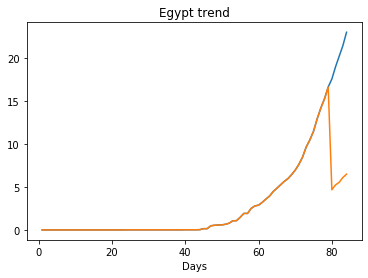

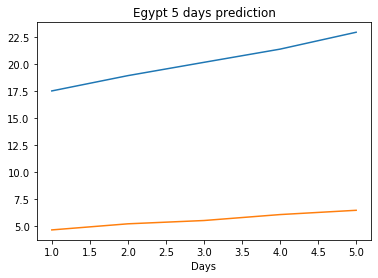

tensor([[3.4928, 3.4928, 3.6383, 3.7839, 5.0937]], device='cuda:0')
tensor([ 0.0212, -0.0343,  0.0150,  0.1984,  0.3613], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


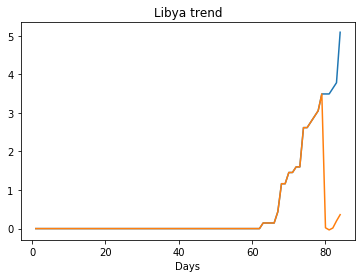

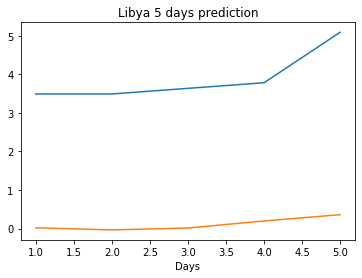

tensor([[39.2300, 41.8579, 45.0007, 47.7641, 51.1507]], device='cuda:0')
tensor([2.4182, 3.1428, 3.7381, 4.8637, 5.6875], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


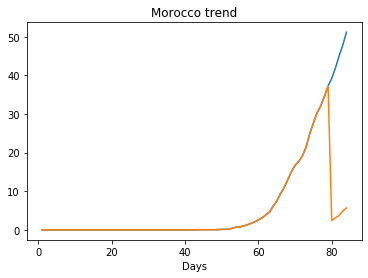

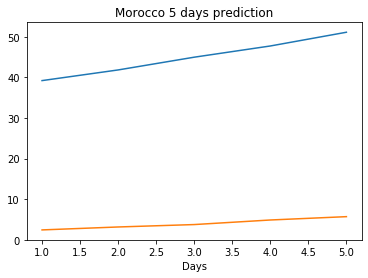

tensor([[0.3877, 0.4333, 0.4333, 0.6614, 0.7298]], device='cuda:0')
tensor([0.0371, 0.0380, 0.0461, 0.0533, 0.0595], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


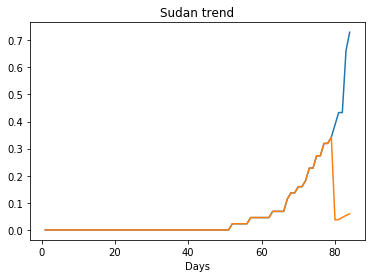

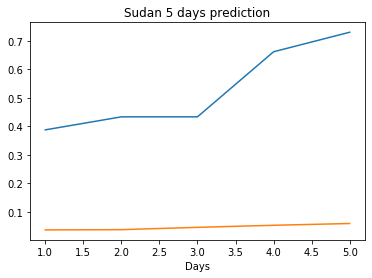

tensor([[56.7748, 57.9594, 59.8209, 61.4285, 63.2053]], device='cuda:0')
tensor([38.9708, 41.5676, 46.2080, 58.5804, 72.5841], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


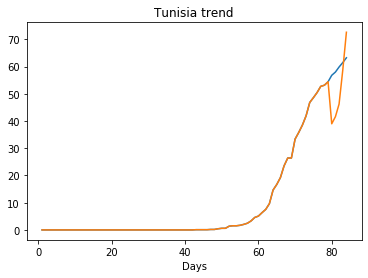

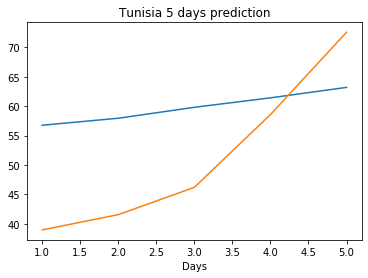

tensor([[ 6.6965,  6.6965, 10.0447, 10.0447, 10.0447]], device='cuda:0')
tensor([ 4.9900e-06,  2.4497e-05, -7.6049e-06, -2.8406e-05, -1.0949e-05],
       device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


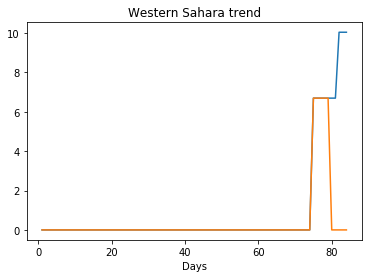

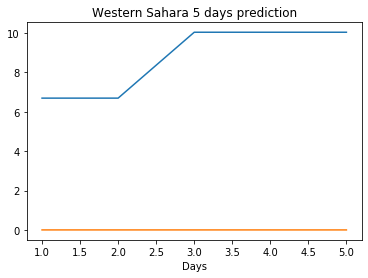

tensor([[316.2090, 326.3331, 341.8567, 350.6309, 360.0800]], device='cuda:0')
tensor([-41.9046, -46.7647, -53.1968, -61.4565, -68.5236], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


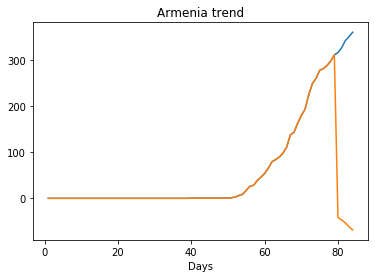

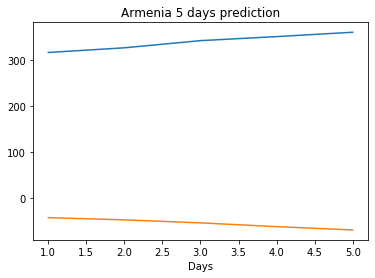

tensor([[ 97.7397, 104.3477, 108.2928, 113.2241, 118.0569]], device='cuda:0')
tensor([13.9031, 16.7934, 21.4927, 25.5621, 30.1952], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


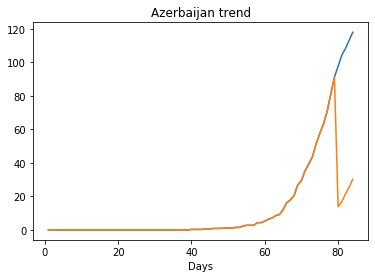

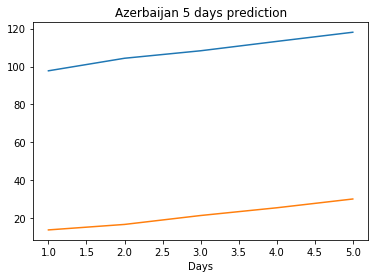

tensor([[543.6124, 611.1967, 667.6148, 799.8448, 897.9890]], device='cuda:0')
tensor([152.9617, 162.4083, 174.6339, 220.0690, 206.4480], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


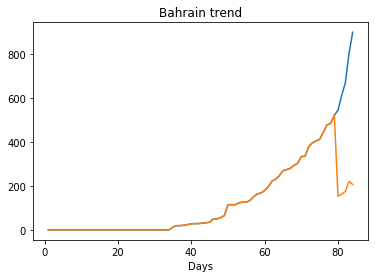

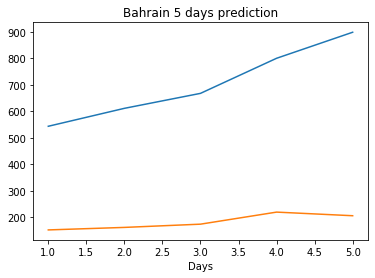

tensor([[492.8108, 510.2041, 524.2844, 548.3037, 575.6361]], device='cuda:0')
tensor([46.6044, 55.3383, 64.3490, 62.4070, 80.9705], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


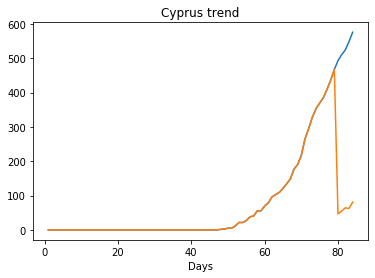

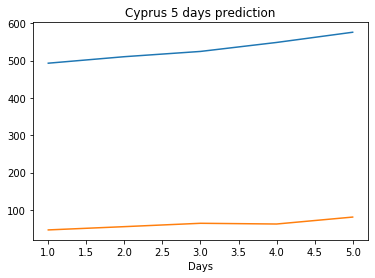

tensor([[58.6587, 60.6641, 64.4243, 68.1844, 75.2034]], device='cuda:0')
tensor([10.3158, 10.7674, 10.6728, 10.9415, 12.0805], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


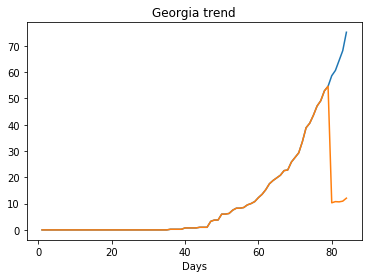

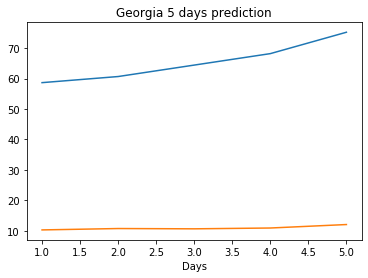

tensor([[31.7981, 32.7677, 33.6130, 34.2594, 34.8064]], device='cuda:0')
tensor([ -7.4938,  -8.8459,  -9.7930, -10.7755, -12.2749], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


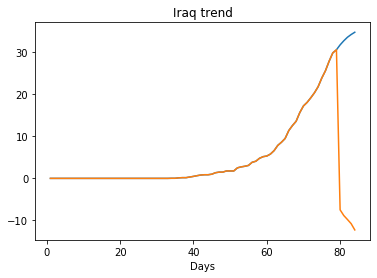

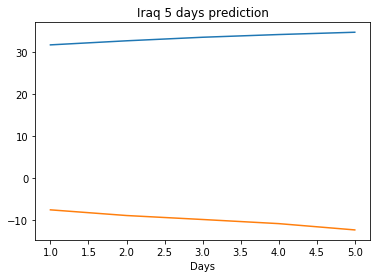

tensor([[1202.4669, 1241.1704, 1287.6146, 1338.5647, 1391.7098]],
       device='cuda:0')
tensor([85.2211, 83.2943, 95.8293, 85.7749, 76.4482], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


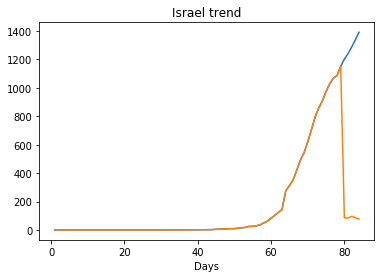

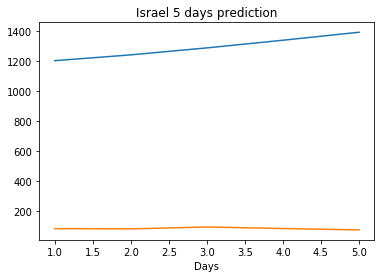

tensor([[36.4594, 37.3414, 38.1255, 38.3215, 38.9096]], device='cuda:0')
tensor([52.3418, 60.0016, 69.3423, 73.0334, 79.7956], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


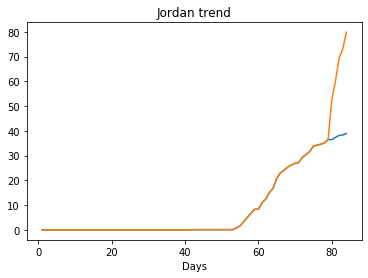

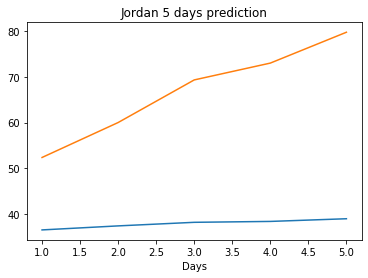

tensor([[232.5222, 270.2222, 288.9551, 304.4097, 317.2886]], device='cuda:0')
tensor([-10.6367, -11.0437, -21.4124, -16.5558, -11.1977], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


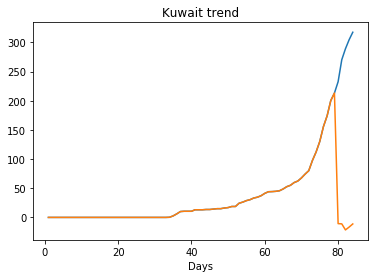

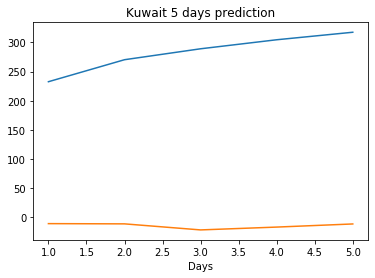

tensor([[89.2250, 90.6901, 92.3017, 92.5948, 93.9134]], device='cuda:0')
tensor([37.6653, 41.6875, 44.3614, 45.6752, 42.1347], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


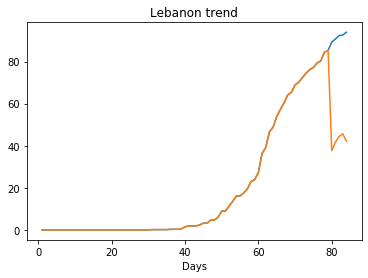

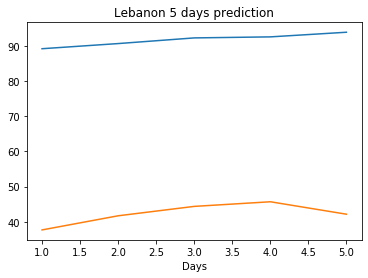

tensor([[ 94.7789, 106.9200, 117.2987, 142.3642, 159.2051]], device='cuda:0')
tensor([ 7.1772, 10.4917, 14.0421, 15.1076, 15.1796], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


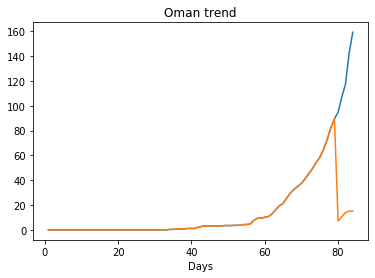

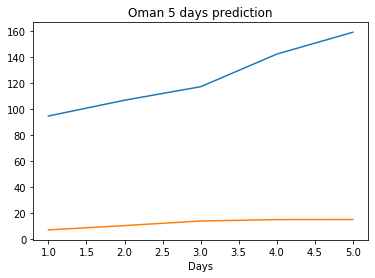

tensor([[ 871.9013,  946.8737, 1033.9944, 1121.4623, 1189.8398]],
       device='cuda:0')
tensor([-109.3740,  -71.7064,  -77.4877,  -22.2899,  -10.4870],
       device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


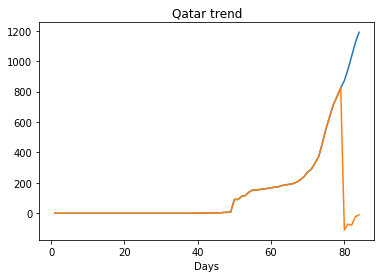

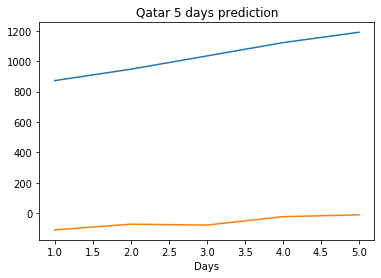

tensor([[104.8720, 115.8446, 128.1673, 141.7251, 154.2201]], device='cuda:0')
tensor([40.0301, 42.5136, 44.6721, 49.4651, 52.5676], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


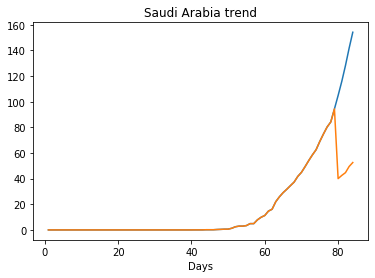

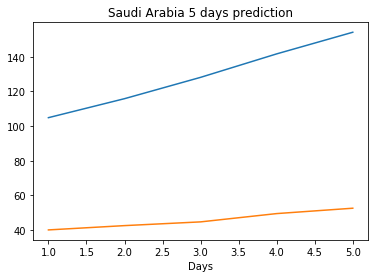

tensor([[1.0857, 1.4285, 1.4285, 1.4285, 1.6571]], device='cuda:0')
tensor([0.0059, 0.0764, 0.0830, 0.0884, 0.0944], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


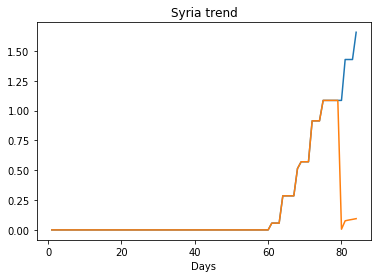

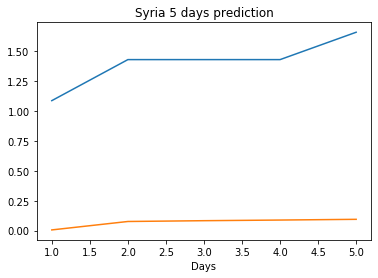

tensor([[557.6182, 618.5389, 675.3217, 723.8519, 772.0146]], device='cuda:0')
tensor([121.2447, 159.5399, 228.0085, 323.1806, 408.8768], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


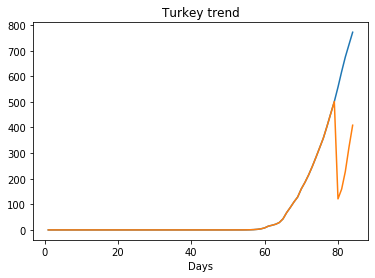

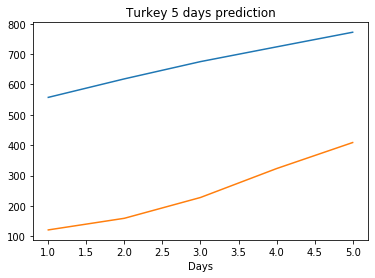

tensor([[339.7234, 377.7400, 416.8689, 457.1099, 498.7665]], device='cuda:0')
tensor([-32.8625, -21.7959, -33.8092, -16.6612, -44.7364], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


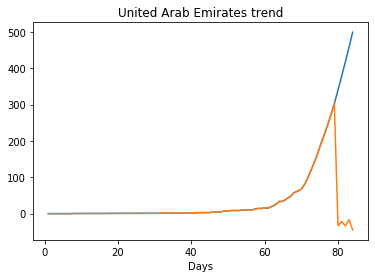

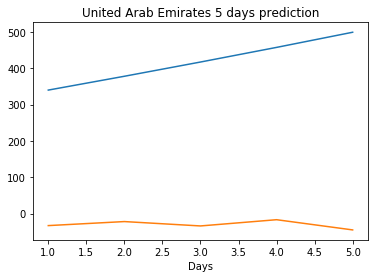

File not accessible
tensor([[43.2451, 46.0677, 50.6479, 58.1039, 65.6132]], device='cuda:0')
tensor([1.9643, 2.1797, 3.1055, 3.9675, 4.0980], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


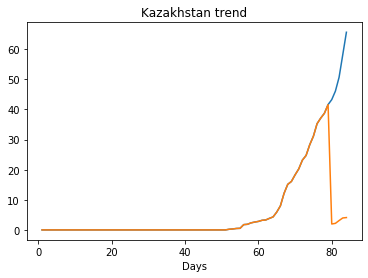

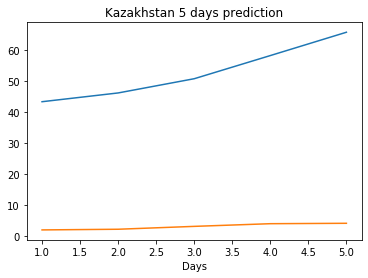

tensor([[45.6762, 51.9605, 57.7850, 64.2225, 65.9086]], device='cuda:0')
tensor([ 5.0562,  6.6746,  7.7581,  8.2437, 10.9688], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


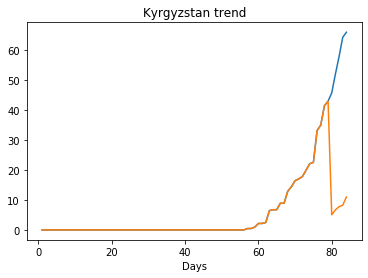

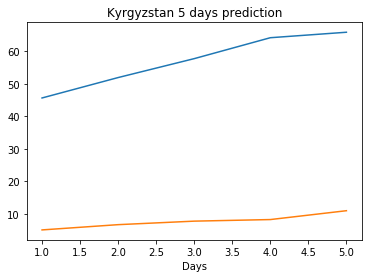

tensor([[18.6440, 22.9166, 25.8447, 29.8185, 34.8081]], device='cuda:0')
tensor([ 3.2265,  4.0631,  5.3662,  7.1020, 10.4886], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


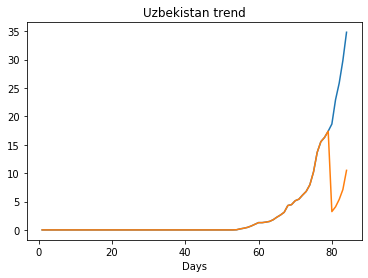

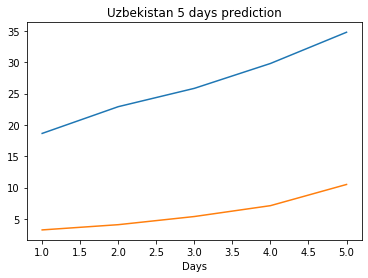

tensor([[13.3836, 14.2570, 15.5928, 17.0827, 18.3414]], device='cuda:0')
tensor([7.4832, 8.3570, 9.5674, 9.6955, 9.2722], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


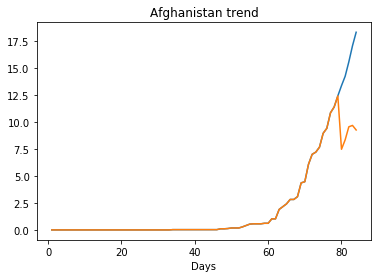

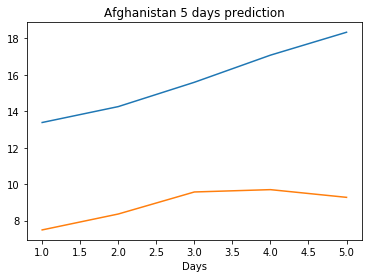

tensor([[2.5745, 2.9267, 3.7707, 4.8758, 6.1449]], device='cuda:0')
tensor([0.5513, 0.7858, 0.8582, 0.8765, 0.9387], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


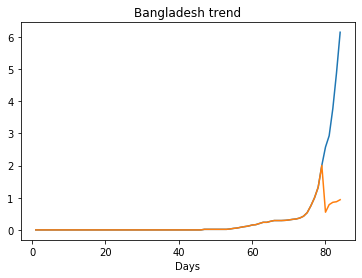

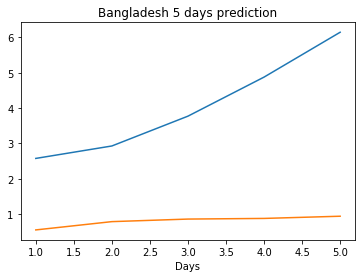

tensor([[6.4800, 6.4800, 6.4800, 6.4800, 6.4800]], device='cuda:0')
tensor([3.8914, 4.3087, 6.1285, 7.2043, 9.1408], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


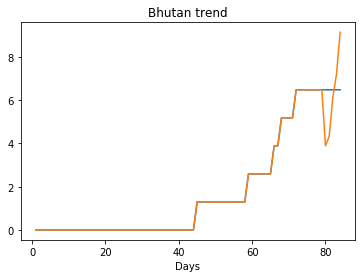

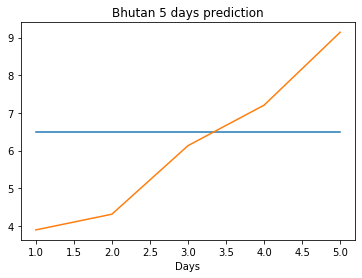

tensor([[5.5058, 6.1203, 6.6703, 7.5746, 8.3239]], device='cuda:0')
tensor([2.9006, 3.2871, 3.8192, 4.3911, 4.8830], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


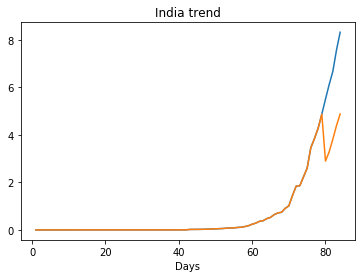

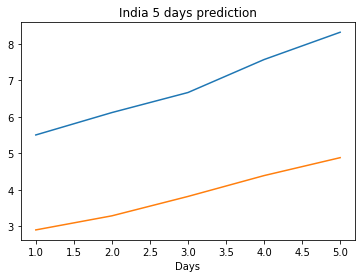

tensor([[811.8777, 833.7485, 853.4764, 872.7280, 891.4677]], device='cuda:0')
tensor([68.8539, 69.0111, 73.2738, 78.9607, 85.0892], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


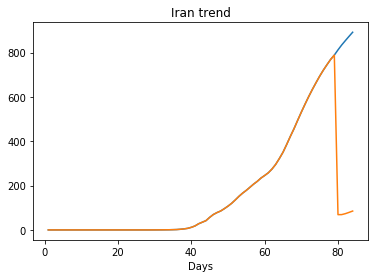

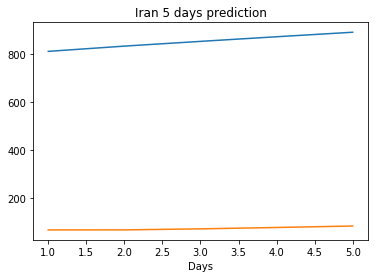

tensor([[35.1500, 35.1500, 37.0000, 37.0000, 37.0000]], device='cuda:0')
tensor([18.7347, 16.5805, 18.6218, 19.4402, 22.9238], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


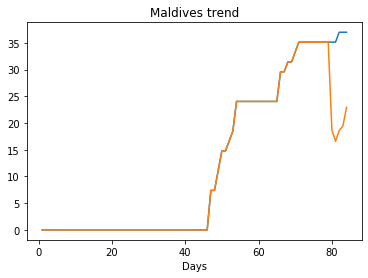

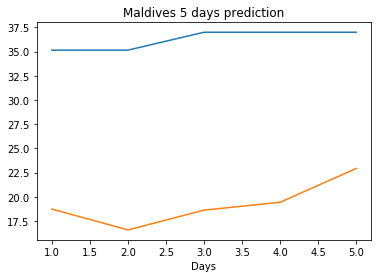

tensor([[0.3089, 0.3089, 0.4119, 0.4805, 0.5491]], device='cuda:0')
tensor([0.0355, 0.0373, 0.0366, 0.0512, 0.0585], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


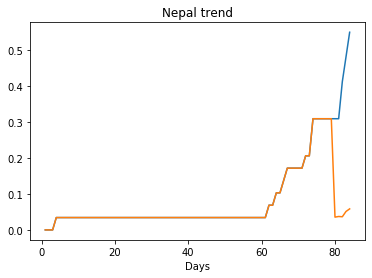

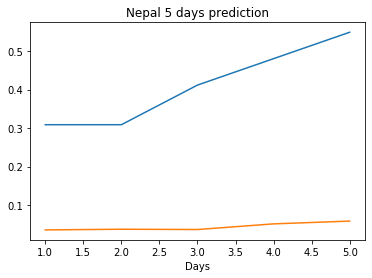

tensor([[21.2547, 22.6853, 23.6767, 24.8809, 26.4246]], device='cuda:0')
tensor([4.1373, 4.7533, 5.5146, 6.0172, 6.5171], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


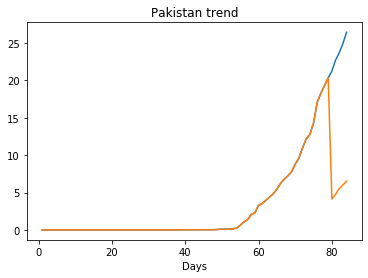

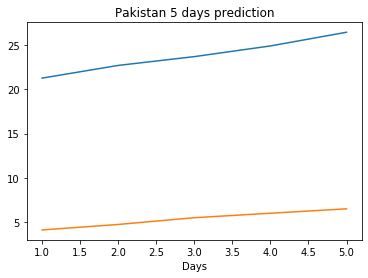

tensor([[ 8.8730,  9.2466,  9.8070, 10.1339, 10.8811]], device='cuda:0')
tensor([5.2553, 5.1894, 5.1764, 5.2926, 5.2165], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


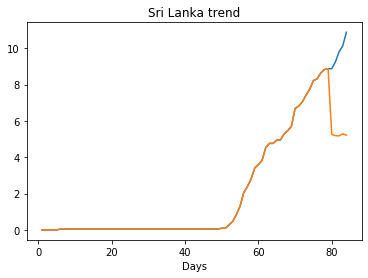

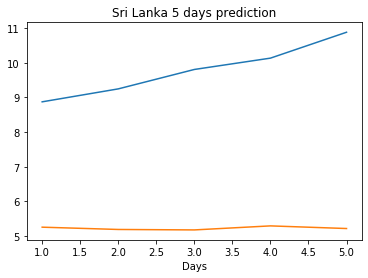

tensor([[16.0391, 16.1651, 16.2910, 16.5010, 16.5010]], device='cuda:0')
tensor([5.5257, 6.2981, 7.7463, 8.7607, 9.6820], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


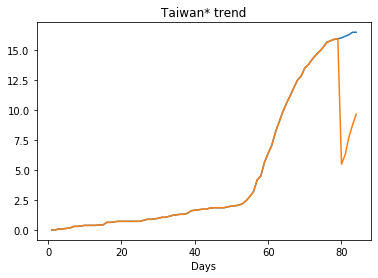

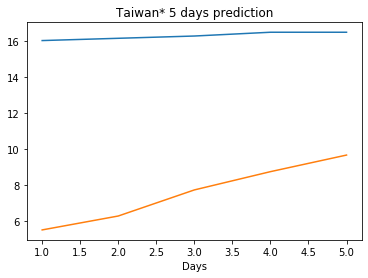

tensor([[405.3716, 406.5353, 407.7766, 408.7464, 409.7938]], device='cuda:0')
tensor([314.5179, 335.4195, 346.0482, 364.6779, 373.4105], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


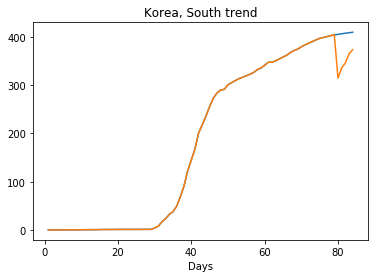

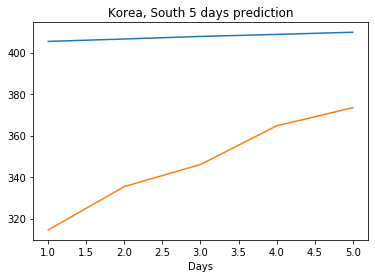

tensor([[43.7236, 47.4792, 53.3538, 58.2717, 60.4460]], device='cuda:0')
tensor([10.6002, 11.3212, 11.6649, 12.9744, 15.4542], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


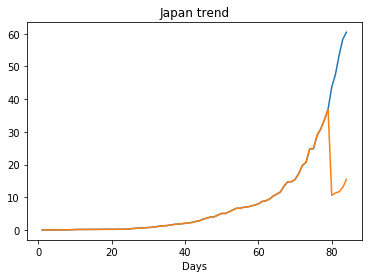

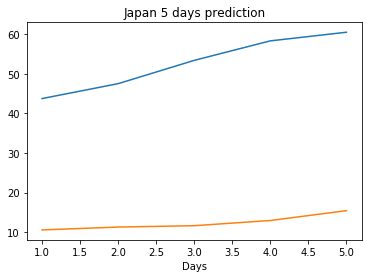

tensor([[4.8806, 4.8806, 4.8806, 5.1856, 9.1511]], device='cuda:0')
tensor([2.9264, 2.9416, 2.7017, 2.6988, 2.7047], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


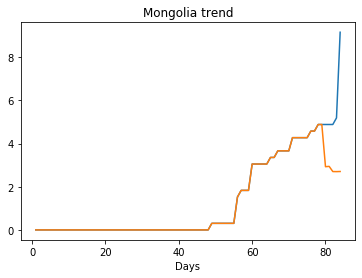

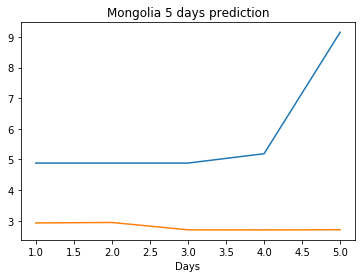

tensor([[310.8714, 310.8714, 310.8714, 310.8714, 310.8714]], device='cuda:0')
tensor([226.3263, 238.1494, 233.6521, 261.5169, 263.1550], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


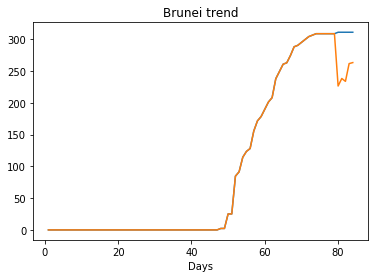

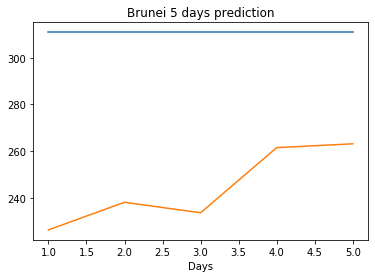

tensor([[7.1177, 7.1775, 7.2971, 7.2971, 7.2971]], device='cuda:0')
tensor([6.2223, 6.0652, 6.1491, 5.8738, 5.9724], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


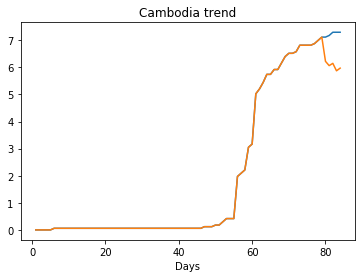

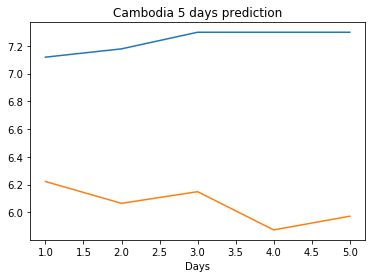

tensor([[12.8398, 14.0463, 15.5051, 16.6604, 17.6913]], device='cuda:0')
tensor([4.7407, 5.2123, 6.1988, 6.7354, 7.1478], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


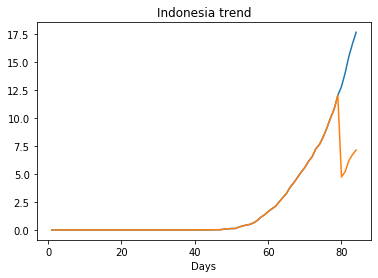

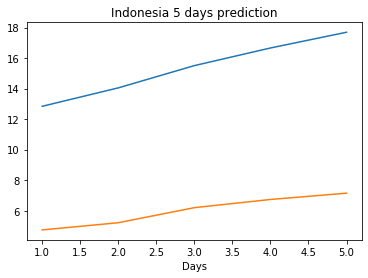

tensor([[2.1991, 2.4740, 2.6115, 2.6115, 2.6115]], device='cuda:0')
tensor([0.1740, 0.3154, 0.3459, 0.3791, 0.4636], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


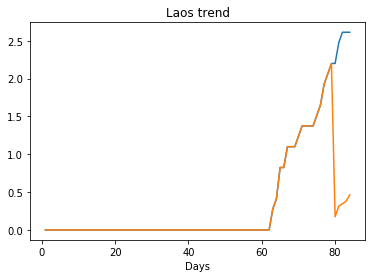

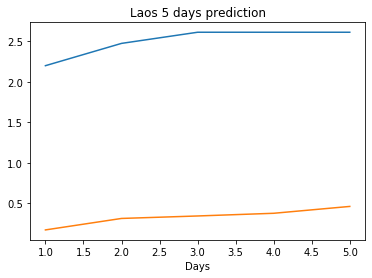

tensor([[134.2767, 139.9617, 144.6889, 148.8290, 154.0814]], device='cuda:0')
tensor([20.9920, 29.4108, 33.8202, 48.2229, 57.9126], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


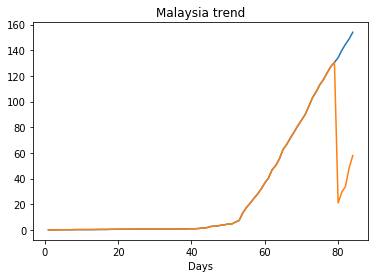

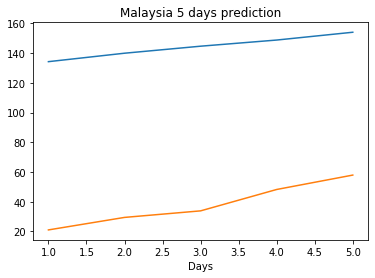

tensor([[38.2822, 40.4084, 42.4161, 45.0078, 47.6633]], device='cuda:0')
tensor([4.7726, 5.4537, 6.2506, 7.5693, 9.4621], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


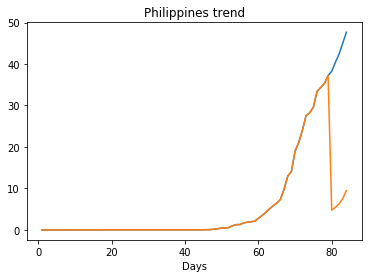

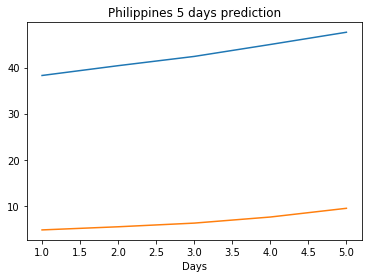

tensor([[360.3210, 392.9686, 432.7953, 498.7744, 555.8651]], device='cuda:0')
tensor([-43.1567, -46.6022, -51.2289, -64.4740, -63.4373], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


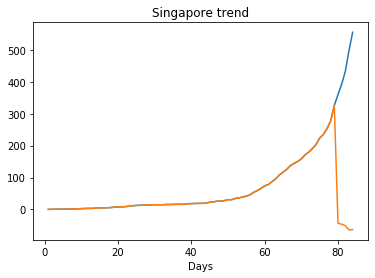

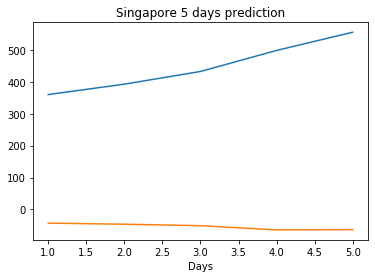

tensor([[35.4298, 36.0745, 36.5473, 36.9484, 37.4355]], device='cuda:0')
tensor([1.8566, 2.7930, 4.4163, 5.3752, 5.2818], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


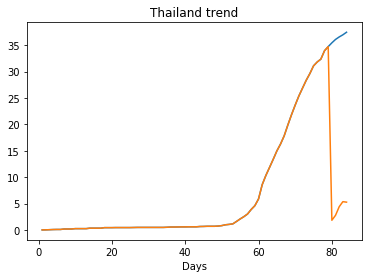

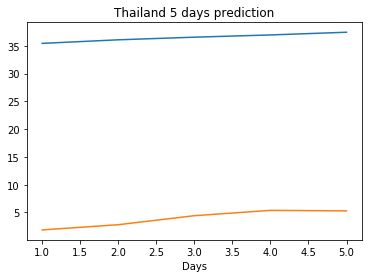

tensor([[1.5169, 1.5169, 1.5169, 3.0339, 4.5508]], device='cuda:0')
tensor([0.8978, 0.6854, 0.8060, 0.8706, 0.7739], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


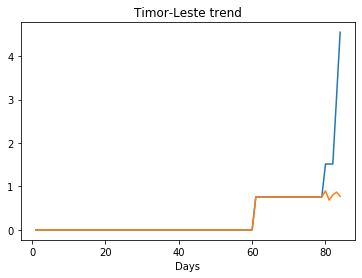

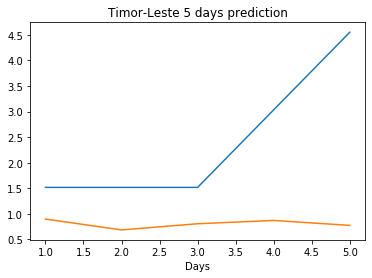

tensor([[2.6403, 2.6505, 2.6916, 2.7225, 2.7327]], device='cuda:0')
tensor([2.2673, 2.4754, 2.6051, 2.7807, 2.8155], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


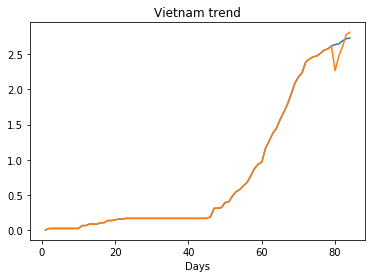

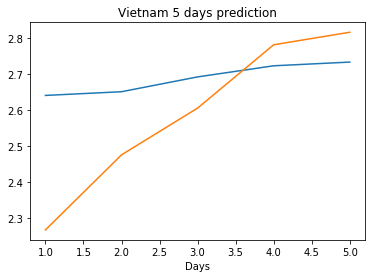

tensor([[194.0161, 214.4389, 214.4389, 234.8616, 234.8616]], device='cuda:0')
tensor([136.4299, 108.2449, 344.6300, 437.0831, 340.1561], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


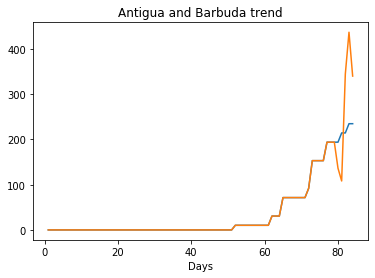

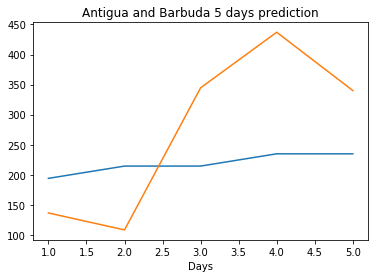

tensor([[106.8023, 116.9739, 116.9739, 119.5168, 124.6027]], device='cuda:0')
tensor([ 7.7251, 10.1058, 12.6494, 17.5205, 18.7489], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


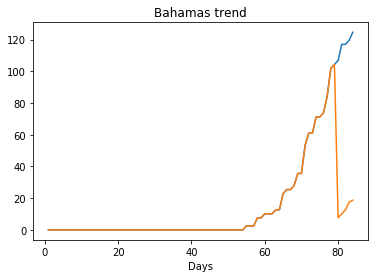

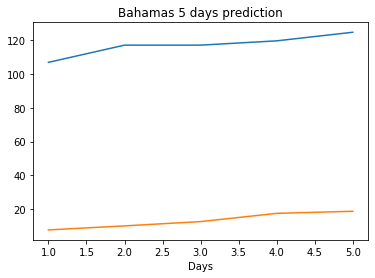

tensor([[233.1489, 236.6287, 247.0682, 250.5481, 250.5481]], device='cuda:0')
tensor([ 33.0820,  31.4177, -31.6765,  20.0814,  -2.9472], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


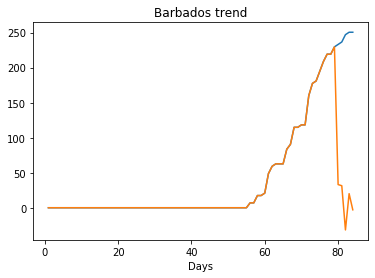

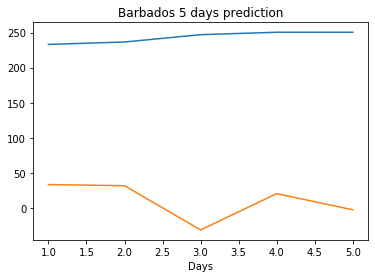

tensor([[49.7942, 54.7383, 59.0644, 64.0968, 67.6283]], device='cuda:0')
tensor([3.4548, 4.1786, 4.8940, 6.1377, 7.8012], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


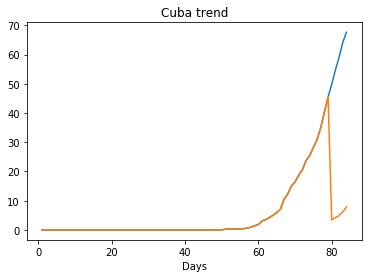

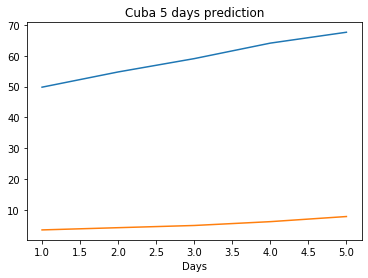

tensor([[222.2531, 222.2531, 222.2531, 222.2531, 222.2531]], device='cuda:0')
tensor([265.7625, 284.8007, 154.3470, 156.5332, 147.3353], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


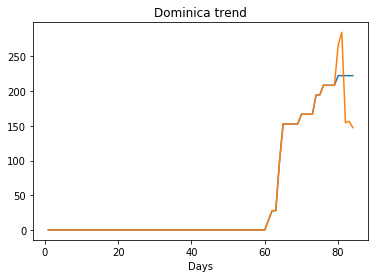

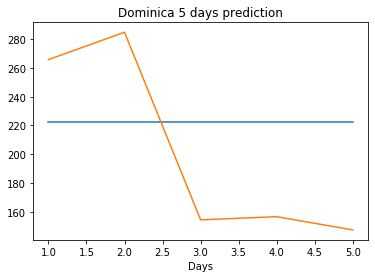

tensor([[241.5214, 254.3349, 273.5092, 291.9459, 302.9158]], device='cuda:0')
tensor([ 75.0665,  86.2049, 103.2851, 121.7947, 145.4884], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


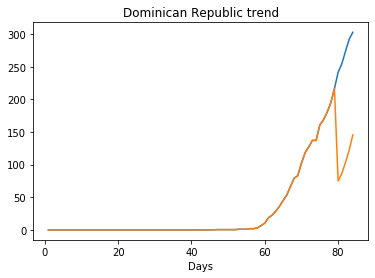

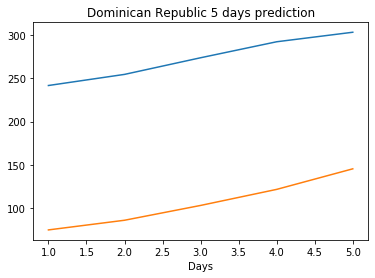

tensor([[124.4223, 124.4223, 124.4223, 124.4223, 124.4223]], device='cuda:0')
tensor([   7.7459, -124.9540,  106.0163,   57.2957,    7.7309],
       device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


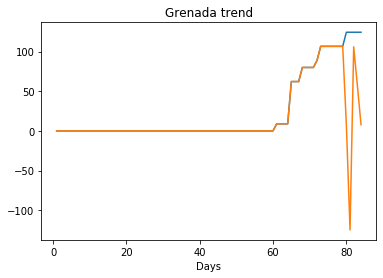

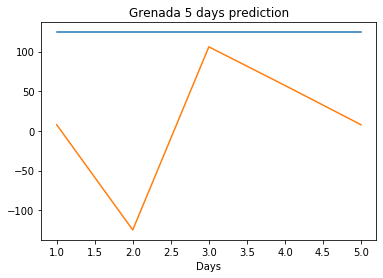

tensor([[2.7187, 2.8941, 2.8941, 3.5080, 3.5080]], device='cuda:0')
tensor([2.5317, 2.7038, 2.7532, 2.6948, 3.8290], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


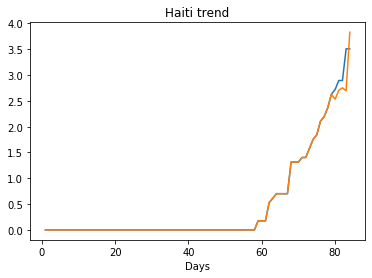

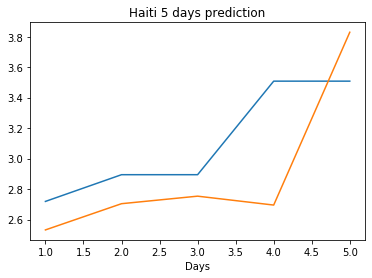

tensor([[21.2754, 21.9509, 23.3017, 24.6525, 24.6525]], device='cuda:0')
tensor([10.6897, 11.4591, 11.8961, 12.8204, 13.6204], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


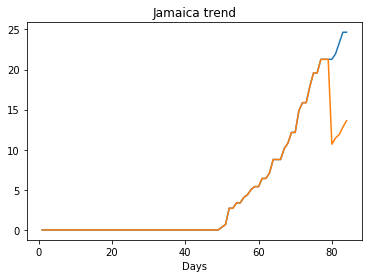

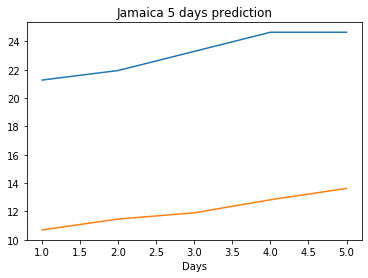

tensor([[225.6063, 225.6063, 225.6063, 225.6063, 263.2074]], device='cuda:0')
tensor([-5.9566, -4.7273, -2.4976, -3.5739, -5.8934], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


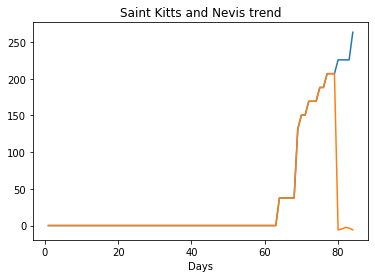

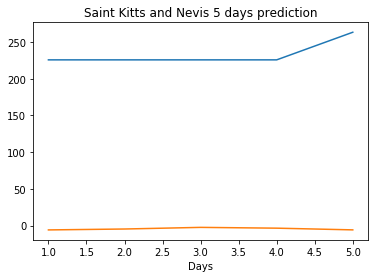

tensor([[81.6860, 81.6860, 81.6860, 81.6860, 81.6860]], device='cuda:0')
tensor([24.1230, 23.1946, 19.0654, 17.5937, 50.8358], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


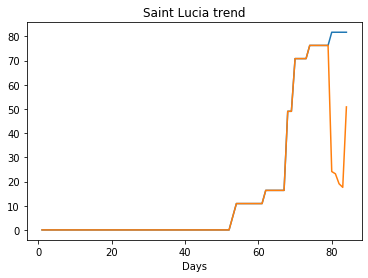

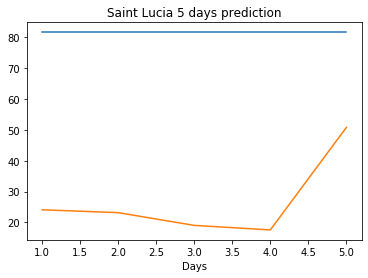

tensor([[108.1568, 108.1568, 108.1568, 108.1568, 108.1568]], device='cuda:0')
tensor([9.1254, 4.1901, 1.8518, 1.2382, 3.8273], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


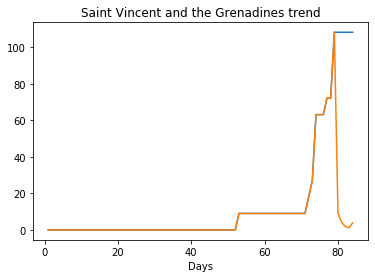

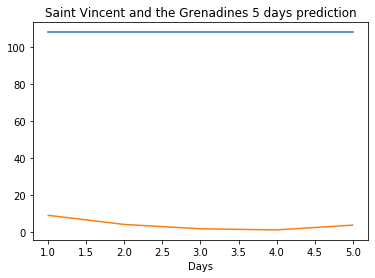

tensor([[77.8855, 80.0292, 80.7437, 80.7437, 80.7437]], device='cuda:0')
tensor([ -5.5825, -11.5375, -25.1709, -26.3760, -28.6894], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


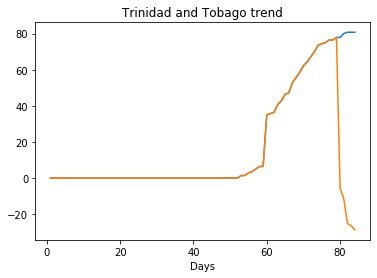

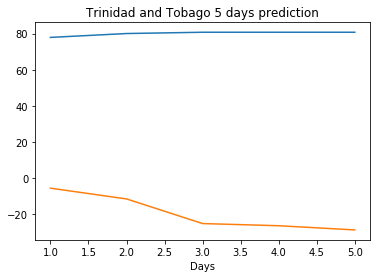

tensor([[25.1496, 32.6945, 35.2095, 45.2694, 45.2694]], device='cuda:0')
tensor([5.2191, 5.1340, 5.2363, 4.8647, 4.6047], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


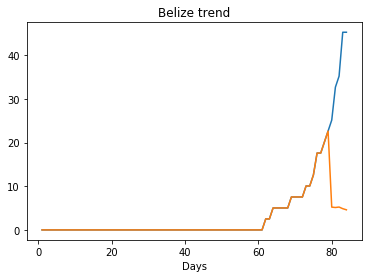

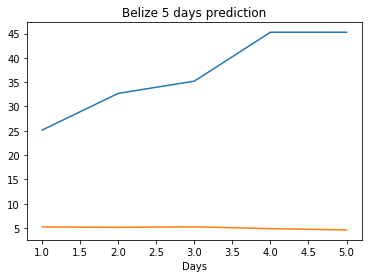

tensor([[109.5383, 113.2681, 116.8016, 120.1387, 121.3166]], device='cuda:0')
tensor([58.7886, 69.1605, 79.3235, 90.4078, 98.8306], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


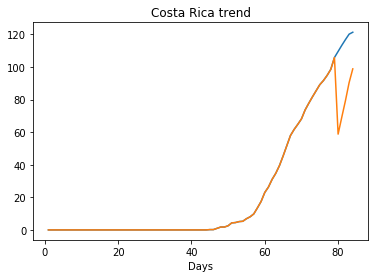

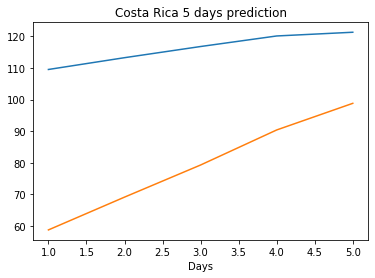

tensor([[18.0383, 18.1925, 19.2717, 21.1218, 22.9718]], device='cuda:0')
tensor([ 4.2612,  6.3256,  7.7726, 10.5276, 13.2018], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


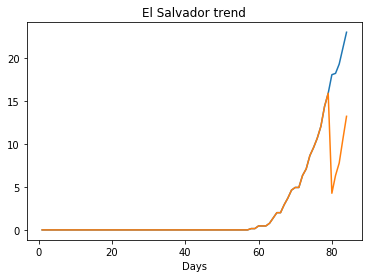

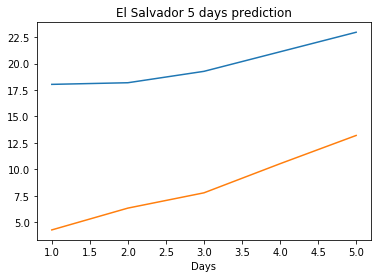

tensor([[7.0330, 7.6470, 8.6517, 8.7075, 9.3215]], device='cuda:0')
tensor([1.2625, 1.2001, 1.2578, 1.4458, 1.5637], device='cuda:0')


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


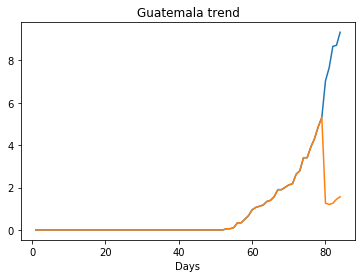

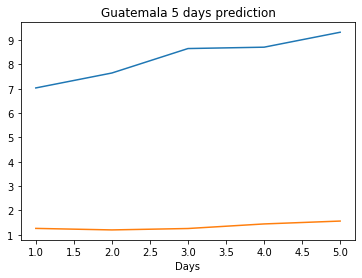

File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible
File not accessible


In [43]:
lstm_input_size = t_days
batch_size = 1
output_dim = pred_days

hdim = []
nLayer = []
tloss = []
ntloss = []

country_result = dict()
graph_dir = "./graph/"
directory = os.path.dirname(graph_dir)
if not os.path.exists(directory):
    print("Creating directory %s" % graph_dir)
    os.makedirs(directory)
else:
     print("Directory %s exists" % graph_dir)
criterion = torch.nn.MSELoss()
nogo = ['Honduras','Mexico','Nicaragua','Panama','Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Guyana']

for i in range(len(countries)):
    country_result[countries[i]]=[]
    if countries[i] in nogo:
        continue
    
    # find the best validation error (by going through files)
    output_file_path = "offline/"+countries[i]+"/training/"
    
    try:
        f = open(output_file_path+countries[i]+".th")
        # Do something with the file
    except IOError:
        print("File not accessible")
        nogo.append(countries[i])
        continue
    finally:
        f.close()
    
    #learning_rate = best_param[0]
    hidden_dim = int(torch.load(output_file_path+countries[i]+".th")['lstm.weight_ih_l0'].shape[0]/4)
    num_layers = int((len(torch.load(output_file_path+countries[i]+".th"))-2)/4)
    best_param = [hidden_dim,num_layers]
    
    hdim.append(hidden_dim)
    nLayer.append(num_layers)
    
    net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
    #print(net)
    model = net.to(device)
    
    

    model.load_state_dict(torch.load(output_file_path+countries[i]+".th"))
    #model.eval()
    
    # load test
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[i]).unsqueeze_(0).float())
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    pred, test_loss = test_model(test_loader,model,device,criterion)
    #print("prediction: ",pred)
    tloss.append(test_loss)
    ntloss.append(test_loss/max(country_test_Y[i]))
    
    country_result[countries[i]].extend([best_param,[country_test_Y[i],pred],test_loss])
    
    # graph 
    graph_country(i,pred.tolist(),graph_dir)
    

In [44]:
a = pred.tolist()
b = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16819754465224315, 0.16819754465224315, 0.25229631697836474, 0.25229631697836474, 0.25229631697836474]
print(len(b))
b.extend(a)
print(b)
print(len(b))

74
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16819754465224315, 0.16819754465224315, 0.25229631697836474, 0.25229631697836474, 0.25229631697836474, 1.2624976634979248, 1.2001162767410278, 1.2577928304672241, 1.4458377361297607, 1.563742756843567]
79


In [ ]:

import json
with open("country_summary_tg.js",'w+') as outfile:
    json.dump(country_result, outfile , sort_keys = True , indent = 4, separators = (",",": "))

### Show result:
* distribution of the hyper-parameter
* MSE distribution (histogram)
* MSE normalized to max of value (histogram)

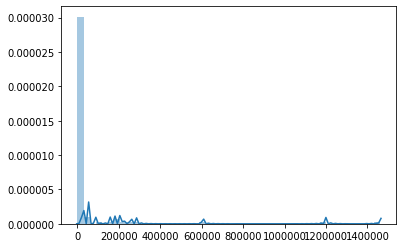

In [25]:
sns.distplot(np.array(tloss));


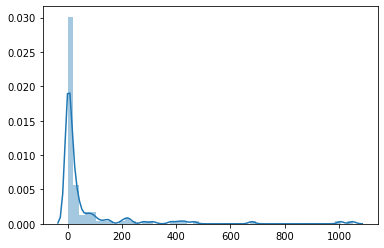

In [24]:
sns.distplot(np.array(ntloss));

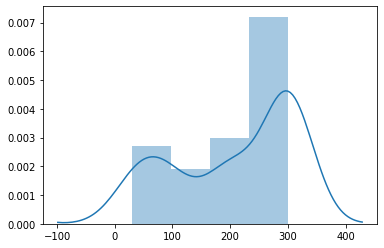

In [45]:
sns.distplot(np.array(hdim));

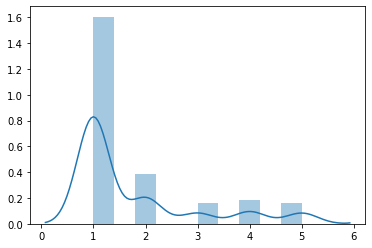

In [46]:
sns.distplot(np.array(nLayer));